# Tweets Labeler

## Setup Snorkel Session and Load Data
Creates a snorkel session on SQLite database and loads tweets.

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from snorkel import SnorkelSession
session = SnorkelSession()

In [2]:
from snorkel.models import candidate_subclass

Exercise = candidate_subclass('Exercise', ['content'])

In [3]:
import pandas as pd

docs = []
tweets_file_path = 'data/unlabeled_tweets.tsv'

tweets = pd.read_csv(tweets_file_path, sep = '\t')
for idx, row in tweets.iterrows():
    docs.append(row['content'])
    
train_set = set()
dev_set = set()
test_set = set()

for i, doc in enumerate(docs):
    if i % 10 == 8:
        dev_set.add(doc)
    elif i % 10 == 9:
        test_set.add(doc)
    else:
        train_set.add(doc)    

In [4]:
from snorkel.candidates import CandidateExtractor
cand_extractor = CandidateExtractor(Exercise, [], [])

In [5]:
%%time
for i, docs in enumerate([train_set, dev_set, test_set]):    
    cand_extractor.apply(docs, split=i)
    print("Number of candidates:", session.query(Exercise).filter(Exercise.split == i).count())

Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 1307)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 163)
Clearing existing...
Running UDF...
[========================================] 100%

('Number of candidates:', 163)
CPU times: user 964 ms, sys: 168 ms, total: 1.13 s
Wall time: 1.4 s


In [6]:
# Load Gold Labels
from util import load_external_labels
%time missed = load_external_labels(session, Exercise, annotator_name='gold')

AnnotatorLabels created: 18
AnnotatorLabels created: 24
CPU times: user 920 ms, sys: 0 ns, total: 920 ms
Wall time: 1.24 s


In [7]:
# Load existing dev and test sets
from snorkel.annotations import load_gold_labels

L_gold_dev = load_gold_labels(session, annotator_name='gold', split=1)
L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)
print(L_gold_dev.shape, L_gold_test.shape)

((163, 1), (163, 1))


## Labeling Functions (LFs)
LF is a python function that accepts a tweet and returns 1 if it marks it relevant, 2 if irrelevant, 3 if junk, or 0 to abstain.

In [8]:
# Looks for a kb phrase in the tweet
kb = 'data/kb.txt'
def is_exercise(c):
    with open(kb) as f:
        for phrase in f:
            if c.content.find(phrase.strip()) >= 0:
                return True
        return False

In [9]:
import spacy
nlp = spacy.load('en')

# Look for person names
def has_person(c):
    ents = [e.label_ for e in nlp(c.content).ents]
    for l in ents:
        if l == 'PERSON':
            return True
    return False

In [10]:
ME = ["I", "me", "Me", "I'm", "I am", "i am", "im", "we", "WE", "We"]
NOTME = ["He", "She", "he", "she", "His", "his", "her", "our", "your", "my", "My", "Your", "Our", "they", "They", "Their", "their"]

def LF_1(c):
    if is_exercise(c):
        for me in ME:
            if me in c.content.split():
                #print('me = {0} => {1}'.format(me, c.content))
                return 1
        return 0
    return 3

In [11]:
def LF_2(c):
    if is_exercise(c):
        if has_person(c):
            return 2
        else:
            for o in NOTME:
                if o in c.content.split():   
                    #print('other = {0} => {1}'.format(o, c.content))
                    return 2
            return 0
    return 3               

In [12]:
def LF_3(c):    
    for idx, tweet in tweets.iterrows():
        if c.content == tweet['content']:
            #print('content = {0}, label = {1}'.format(c.content, tweet['label']))
            return tweet['label']
    return 0

In [13]:
# Use weak classifier
from snorkel.weak_classifier import train_classifier, classify

# First train the classifier
vec, clf = train_classifier()

def LF_weak_classifier(c):
    label = classify(vec, clf, [c.content])
    return label

In [14]:
# Group LFs in a list for later use
LFs = [LF_1, LF_2, LF_3, LF_weak_classifier]

In [15]:
# Check size of dev set labeled as exercise tweets using LF_distant_supervision
labeled = []
for c in session.query(Exercise).filter(Exercise.split == 1):
    if LF_weak_classifier(c) == 1:
        labeled.append(c)
print("Number labeled:", len(labeled))

('Number labeled:', 34)


In [16]:
# Apply LFs
from snorkel.annotations import LabelAnnotator
labeler = LabelAnnotator(lfs=LFs)

In [17]:
# Run labeler
import numpy as np
np.random.seed(1701)
%time L_train = labeler.apply(split=0)
L_train

Clearing existing...
Running UDF...
[========================================] 100%

CPU times: user 1min 14s, sys: 1.28 s, total: 1min 15s
Wall time: 1min 14s


<1307x4 sparse matrix of type '<type 'numpy.int64'>'
	with 4010 stored elements in Compressed Sparse Row format>

In [18]:
L_train.todense()

matrix([[1, 2, 1, 1],
        [1, 2, 3, 1],
        [1, 2, 1, 1],
        ..., 
        [3, 3, 3, 3],
        [0, 2, 1, 1],
        [0, 0, 1, 1]])

In [19]:
# Load the labels as a sparse matrix
%time L_train = labeler.load_matrix(session, split=0)
L_train

CPU times: user 56 ms, sys: 0 ns, total: 56 ms
Wall time: 54.2 ms


<1307x4 sparse matrix of type '<type 'numpy.int64'>'
	with 4010 stored elements in Compressed Sparse Row format>

In [20]:
# View statistics about the resulting label matrix
L_train.lf_stats(session)

,j,Coverage,Overlaps,Conflicts
LF_1,0,0.504208,0.504208,0.329763
LF_2,1,0.563887,0.563887,0.403213
LF_3,2,1.000000,1.000000,0.623565
LF_weak_classifier,3,1.000000,1.000000,0.623565


## The Generative Model

Train a model of the LFs to estimate their accuracies and then combine the outputs of the LFs into a noise-aware training labels set.

In [48]:
from snorkel.learning import GenerativeModel

gen_model = GenerativeModel()
gen_model.train(L_train, epochs=100, decay=0.95, step_size=0.1 / L_train.shape[0], reg_param=1e-6)

Inferred cardinality: 3


In [22]:
gen_model.weights.lf_accuracy

array([ 0.57933113,  0.38535937,  1.18776478,  1.2978771 ])

In [23]:
# Apply gen model to the training candidates to get the noise-aware training label set (training marginals)
train_marginals = gen_model.marginals(L_train)

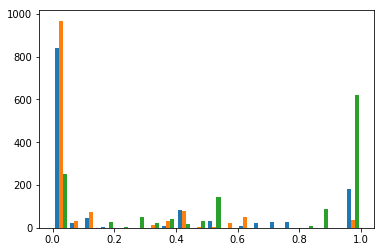

In [24]:
# Distribution of the training marginals
import matplotlib.pyplot as plt
plt.hist(train_marginals, bins=20)
plt.show()

In [25]:
# Learned accuracy parameters, and other statistics about the LFs learned by the generative model
gen_model.learned_lf_stats()

,Accuracy,Coverage
0,0.616031,0.745200
1,0.515870,0.739333
2,0.841968,0.793933
3,0.866711,0.803267


### Iterate on Labeling Functions
Improve the LF set.  First, apply the LFs to the development set:

In [26]:
L_dev = labeler.apply_existing(split=1)

Clearing existing...
Running UDF...
[========================================] 100%



In [27]:
# Get the score of the generative model
correct, incorrect = gen_model.error_analysis(session, L_dev, L_gold_dev)

Accuracy: 0.722222222222


### Save the training labels

Save the `training_marginals` (**probabilistic training labels**) for later use to train an end extraction model:

In [28]:
from snorkel.annotations import save_marginals
%time save_marginals(session, L_train, train_marginals)

Saved 1307 marginals
CPU times: user 1.52 s, sys: 8 ms, total: 1.53 s
Wall time: 1.68 s


## Training an End Extraction Model
Use the noisy training labels to train the end extraction model (Bi-LSTM, a state-of-the-art deep neural network). 

In [29]:
# Reload the probabilistic training labels
from snorkel.annotations import load_marginals
train_marginals = load_marginals(session, split=0)

[[ 0.99316579  0.00467239  0.00216182]
 [ 0.76777548  0.03885356  0.19337096]
 [ 0.99316579  0.00467239  0.00216182]
 ..., 
 [ 0.00100509  0.00100509  0.99798982]
 [ 0.97854889  0.01466562  0.00678549]
 [ 0.98632122  0.00683939  0.00683939]]


In [30]:
# Reload the candidates
train_cands = session.query(Exercise).filter(Exercise.split == 0).order_by(Exercise.id).all()
dev_cands   = session.query(Exercise).filter(Exercise.split == 1).order_by(Exercise.id).all()
test_cands  = session.query(Exercise).filter(Exercise.split == 2).order_by(Exercise.id).all()

In [31]:
# Load the gold labels for evaluation
#from snorkel.annotations import load_gold_labels
#L_gold_dev  = load_gold_labels(session, annotator_name='gold', split=1)
#L_gold_test = load_gold_labels(session, annotator_name='gold', split=2)

In [ ]:
# Get labels of train set
train_candidates = [train_cands[i].content for i in range(len(train_cands))]
Y_train = [t['label'] for c in train_candidates for (i, t) in tweets.iterrows() if c == t['content']] 
Y_train = np.asarray(Y_train)

In [ ]:
# Get labels of dev set
dev_candidates = [dev_cands[i].content for i in range(len(dev_cands))]
Y_dev = [t['label'] for c in dev_candidates for (i, t) in tweets.iterrows() if c == t['content']] 
Y_dev = np.asarray(Y_dev)

In [ ]:
# Get labels of test set
test_candidates = [test_cands[i].content for i in range(len(test_cands))]
Y_test = [t['label'] for c in test_candidates for (i, t) in tweets.iterrows() if c == t['content']] 
Y_test = np.asarray(Y_test)

In [42]:
# Setup the discriminative model
from snorkel.learning.disc_models.rnn import reRNN

train_kwargs = {
    'lr':         0.01,
    'dim':        50,
    'n_epochs':   10,
    'dropout':    0.25,
    'print_freq': 1
}

lstm = reRNN(seed=1701, n_threads=None)
lstm.train(train_cands, train_marginals, X_dev=dev_cands, Y_dev=Y_dev, **train_kwargs)

[reRNN] Training model
[reRNN] n_train=1307  #epochs=10  batch size=256
[reRNN] Epoch 0 (0.53s)	Average loss=0.992643	Dev Acc.=52.76
[reRNN] Epoch 1 (0.95s)	Average loss=0.781714	Dev Acc.=54.60
[reRNN] Epoch 2 (1.27s)	Average loss=0.566189	Dev Acc.=56.44
[reRNN] Epoch 3 (1.58s)	Average loss=0.456253	Dev Acc.=57.06
[reRNN] Epoch 4 (1.89s)	Average loss=0.422172	Dev Acc.=56.44
[reRNN] Epoch 5 (2.20s)	Average loss=0.407709	Dev Acc.=56.44
[reRNN] Epoch 6 (2.50s)	Average loss=0.372940	Dev Acc.=59.51
[reRNN] Epoch 7 (2.80s)	Average loss=0.352447	Dev Acc.=55.83
[reRNN] Epoch 8 (3.11s)	Average loss=0.356618	Dev Acc.=60.74
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (3.56s)	Average loss=0.351773	Dev Acc.=55.21
[reRNN] Training done (3.57s)
INFO:tensorflow:Restoring parameters from checkpoints/reRNN/reRNN-8
[reRNN] Loaded model <reRNN>


In [47]:
# Stats from the discriminative model
train_cands_ac = lstm.score(train_cands, Y_train)
dev_cands_ac = lstm.score(dev_cands, Y_dev)
test_cands_ac = lstm.score(test_cands, Y_test)

print("Accuracy Score:\ntrain = {0:.3f}, dev = {1:.3f}, and test= {2:.3f}".format(train_cands_ac, dev_cands_ac, test_cands_ac))

Accuracy Score:
train = 0.798, dev = 0.607, and test= 0.552
